In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [5]:
df.shape

(145366, 2)

In [6]:
df = df.set_index('Datetime')


In [7]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


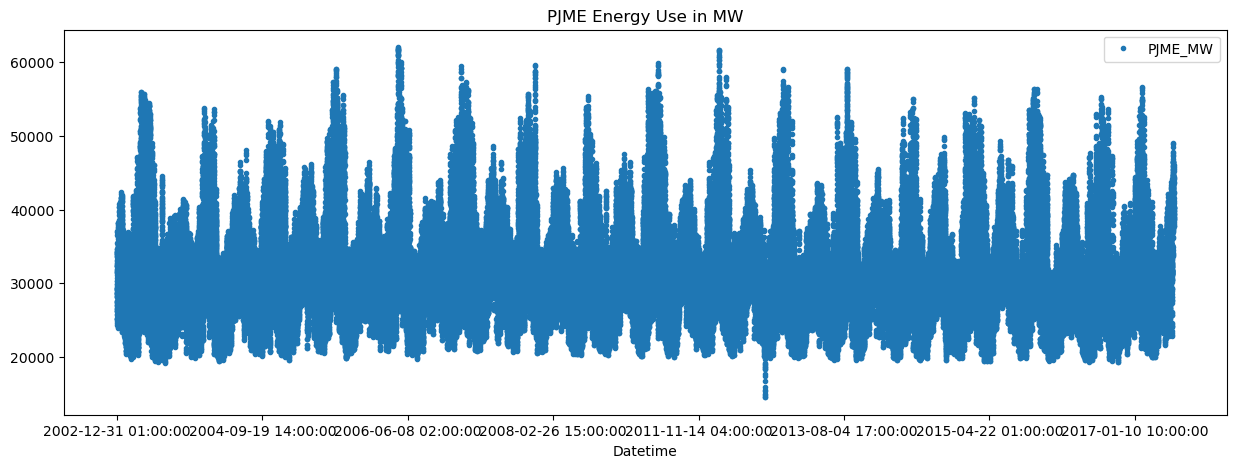

In [8]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title = 'PJME Energy Use in MW')
plt.show()

In [9]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

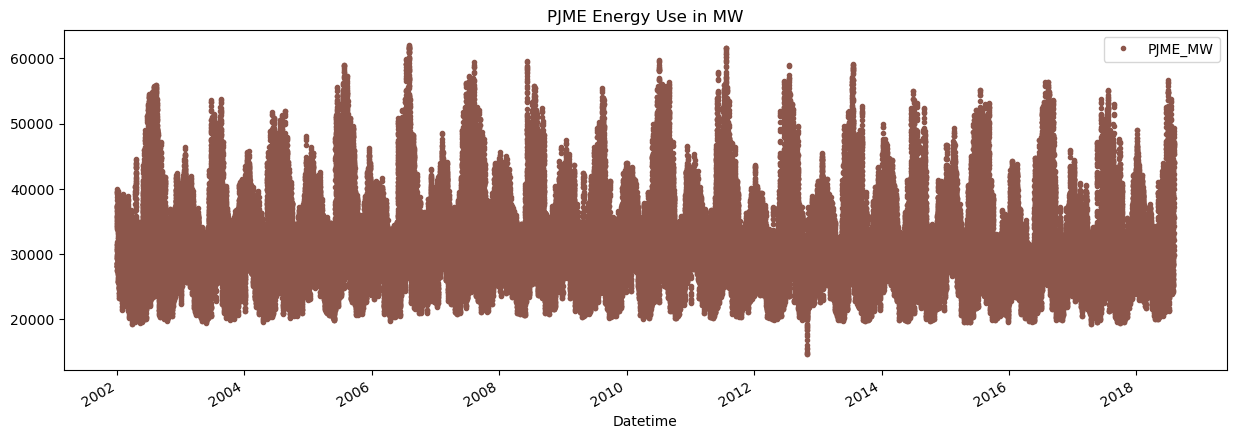

In [12]:
df.plot(style='.',
        figsize=(15, 5), 
        color=color_pal[5], 
        title = 'PJME Energy Use in MW')
plt.show()

In [13]:
df.isnull().sum()

PJME_MW    0
dtype: int64

## Train / Test Split 

In [15]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

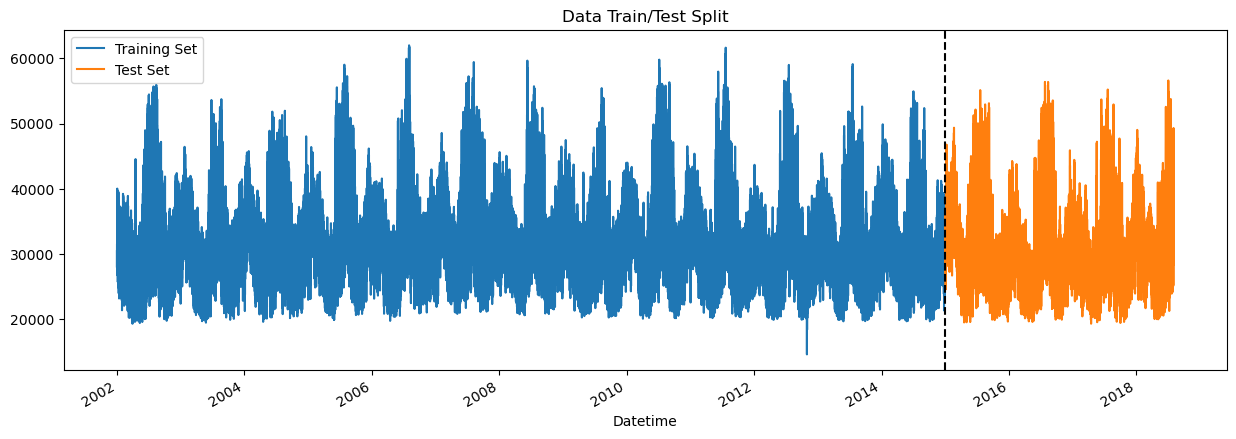

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training set',title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

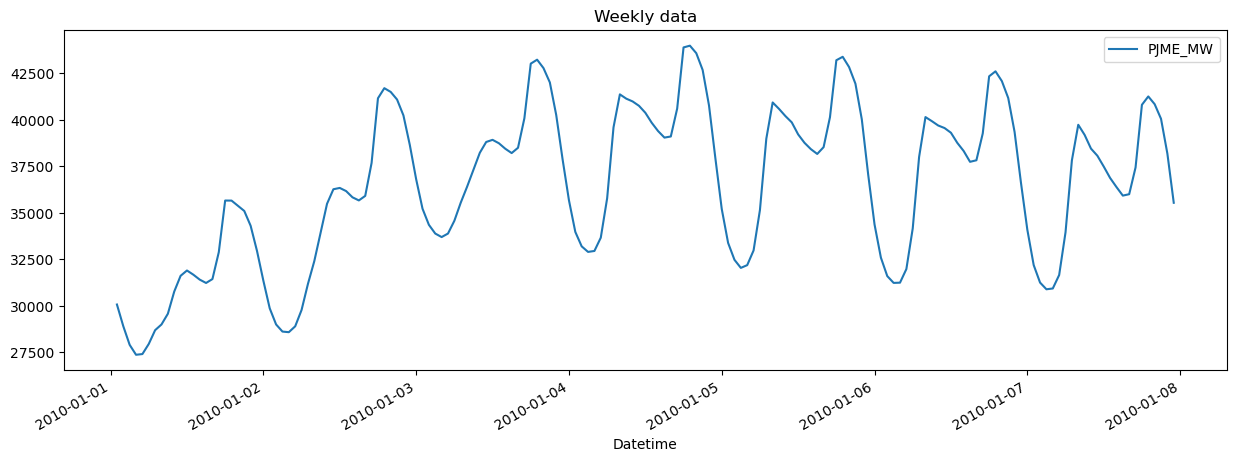

In [23]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Weekly data')
plt.show()

## Feature Creation

In [48]:
def create_features(df):
    """
    Create time seris features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month']= df.index.month
    df['year'] =df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df 


In [40]:
df= create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize our feature/target relationship

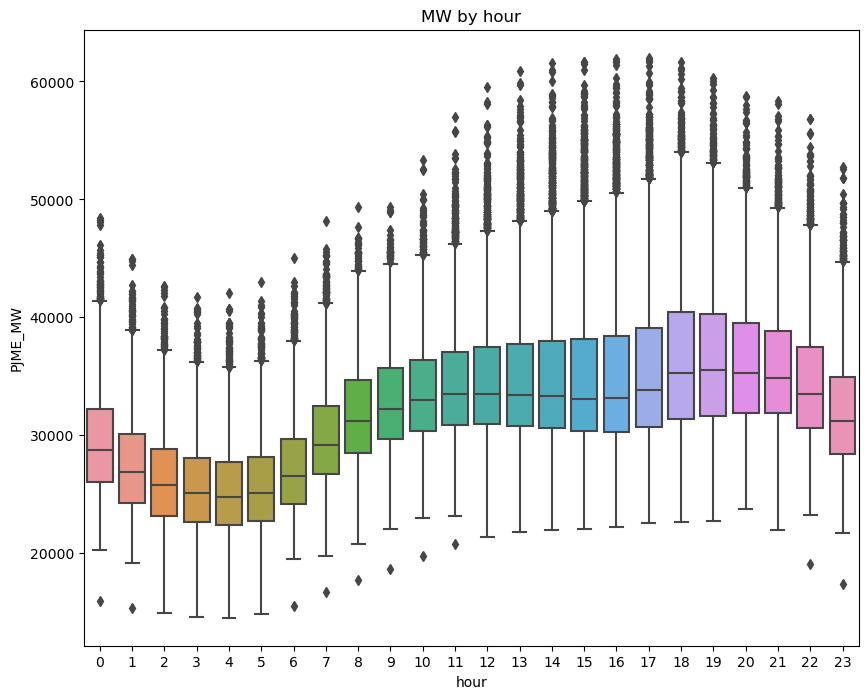

In [42]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

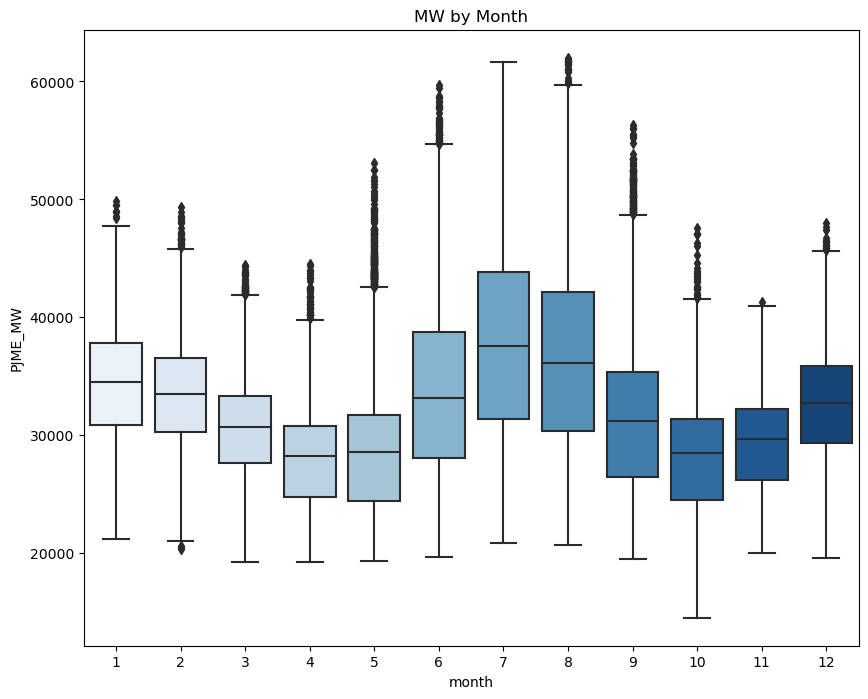

In [45]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette = 'Blues')
ax.set_title('MW by Month')
plt.show()

## Create our model

In [49]:
train = create_features(train)
test = create_features(test)

In [55]:
df.columns 

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [56]:
features=['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'PJME_MW'

In [57]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [64]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate = 0.01)
reg.fit(X_train, y_train , 
       eval_set =[(X_train, y_train), (X_test, y_test)],
        verbose=100
       )

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance


In [68]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_ ,
            columns =['importance'])

In [69]:
fi.sort_values('importance')

,importance
year,0.022634
quarter,0.033319
dayofyear,0.108419
dayofweek,0.158668
month,0.228156
hour,0.448804


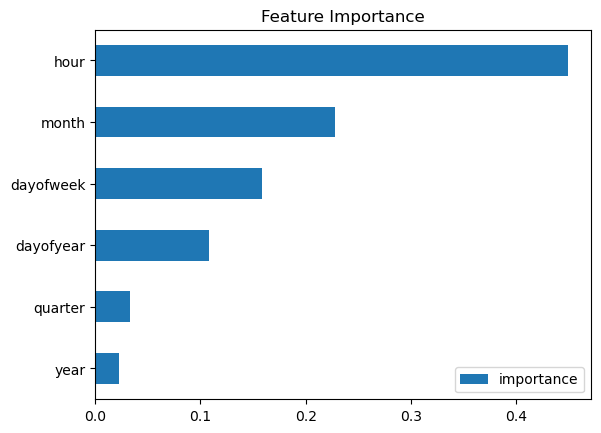

In [71]:
fi.sort_values('importance').plot(kind='barh', title ='Feature Importance')
plt.show()

## Forecast on Test

In [75]:
test['prediction' ] =reg.predict(X_test)

In [78]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31861.591797
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28268.078125
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27164.314453
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26900.753906
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26900.753906


In [80]:
df = df.merge(test[['prediction']], how='left', left_index= True, right_index= True)


In [82]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40829.566406
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40358.277344
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39135.480469


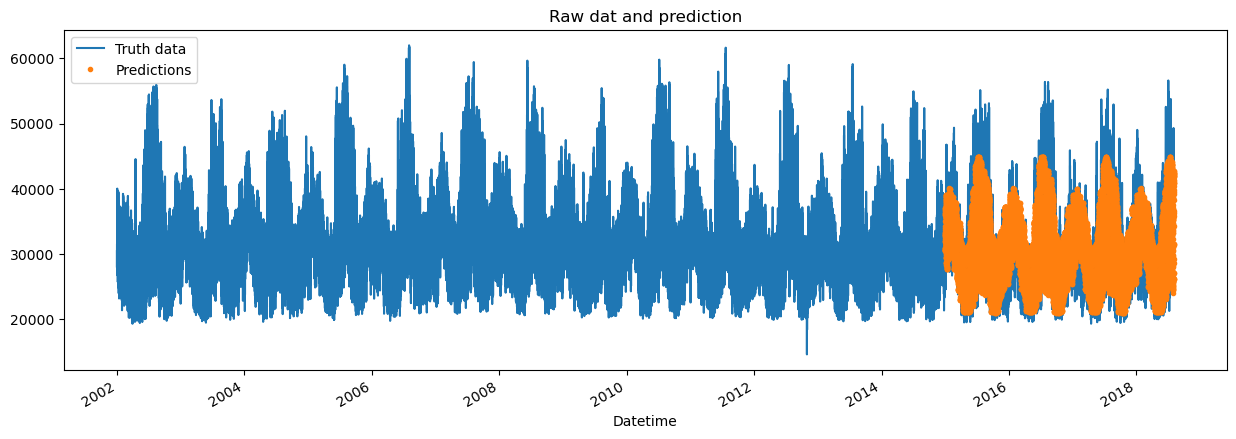

In [83]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth data', 'Predictions'])
ax.set_title('Raw dat and prediction')
plt.show()

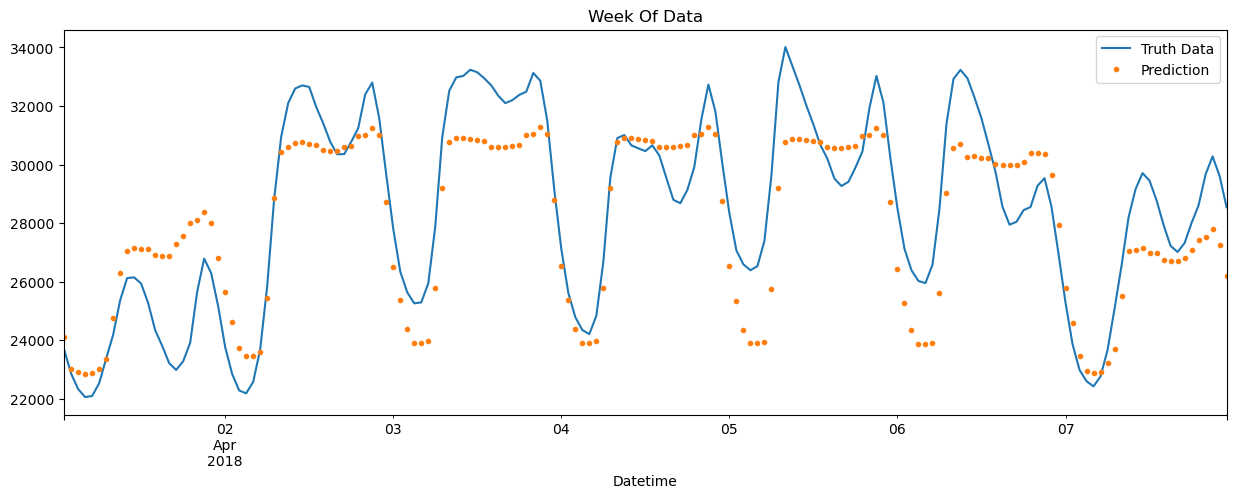

In [84]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [85]:
#we can do better parameter tuning , we could also add in features for specific 
#days of the year like holidays ; that might carry forward to either increase or
#decrease the energy use that it would predict for those days .

In [87]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

In [88]:
score

3715.9314164142415

In [ ]:
#to improve this model, we would want to improve that score 

## Calculate Error

In [90]:
np.abs(test[target] - test['prediction'])

Datetime
2015-01-01 00:00:00     940.408203
2015-12-31 01:00:00    3963.078125
2015-12-31 02:00:00    4008.314453
2015-12-31 03:00:00    4386.753906
2015-12-31 04:00:00    4570.753906
                          ...     
2018-01-01 20:00:00    7428.074219
2018-01-01 21:00:00    7060.183594
2018-01-01 22:00:00    7460.226562
2018-01-01 23:00:00    6915.140625
2018-01-02 00:00:00    6757.263672
Length: 31440, dtype: float64

In [91]:
test['error'] = np.abs(test[target] - test['prediction'])

Look at the worst and best predicted days

In [93]:
test.index.date

array([datetime.date(2015, 1, 1), datetime.date(2015, 12, 31),
       datetime.date(2015, 12, 31), ..., datetime.date(2018, 1, 1),
       datetime.date(2018, 1, 1), datetime.date(2018, 1, 2)], dtype=object)

In [94]:
test['date'] = test.index.date

In [96]:
test.groupby('date')['error'].mean().sort_values()

date
2016-04-04      389.607829
2016-09-27      396.752116
2015-03-10      456.506510
2016-05-01      465.372640
2016-12-08      494.141764
                  ...     
2016-09-09    11369.640299
2016-08-12    11525.418376
2016-09-10    12494.880941
2016-08-14    14472.472738
2016-08-13    14577.210124
Name: error, Length: 1311, dtype: float64

The best predicted days 

In [97]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

The worst predicted days 

In [100]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [101]:
# To improve:
#More robust cross validation
#Add more features(weather forecast, holidays)